<a href="https://colab.research.google.com/github/pedersor/ksr_dft/blob/main/examples/train_test_neural_xc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

Change to GPU runtime: Runtime -> Change runtime type -> Hardware accelerator -> GPU

In [ ]:
# Check cuda version
! nvcc --version

The jaxlib version must correspond to the version of the existing CUDA installation you want to use, with e.g. `cuda111` for CUDA 11.1.

In [ ]:
# For GPU runtime
! pip install --upgrade pip
! pip install --upgrade jaxlib==0.1.72+cuda111 jax==0.2.19 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [ ]:
# Install ksr-dft
! git clone https://github.com/pedersor/ksr_dft.git
! pip install ksr_dft

## Import and setup

In [1]:
import os
from pathlib import Path

import numpy as np
import scipy
import jax
from jax import random
from jax import tree_util
from jax.config import config
import jax.numpy as jnp

from ksr_dft import datasets
from ksr_dft import jit_scf
from ksr_dft import losses
from ksr_dft import neural_xc
from ksr_dft import np_utils
from ksr_dft import scf
from ksr_dft import utils
from ksr_dft import xc
from ksr_dft import analysis
from ksr_dft import ksr


os.environ['XLA_FLAGS'] = '--xla_gpu_deterministic_reductions'
# Set the default dtype as float64. Note: the dtype may switch from float64 to
# float32 during e.g. evaluating/training a convolution neural net. 
config.update('jax_enable_x64', True)

In [2]:
# get path to ksr_dft repo

try:
  import google.colab
  # in Colab
  KSR_DFT_PATH = Path('/content/ksr_dft/')
except:
  # running in local directory
  KSR_DFT_PATH = Path('../')

# Load data

In [3]:
# load atomic systems dataset
ions_dataset = datasets.Dataset(KSR_DFT_PATH / 'data/ions/dmrg', num_grids=513)
grids = ions_dataset.grids

# Train neural XC functional with Kohn-Sham regularizer (KSR)

![](../images/sksr_global.png)

In [4]:
trainer = ksr.SpinKSR(grids)

# set ML model for xc functional
model_dir = 'example_model/'
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

# sKSR-global architecture
network = neural_xc.build_global_local_conv_net_sigma(
    num_global_filters=8,
    num_local_filters=16,
    num_local_conv_layers=2,
    activation='swish',
    grids=grids,
    minval=0.1,
    maxval=2.385345,
    downsample_factor=0,
)
init_fn, neural_xc_energy_density_fn = neural_xc.global_functional_sigma(
    network, grids=grids)

trainer.set_neural_xc_functional(
    model_dir=model_dir,
    neural_xc_energy_density_fn=neural_xc_energy_density_fn)

# set initial params from init_fn
key = jax.random.PRNGKey(0)
trainer.set_init_model_params(init_fn, key, verbose=1)


number of parameters = 1559


Perform training with KSR

![](../images/ksr_training.png)

An example training and validation setup

In [6]:

# set KS parameters
trainer.set_ks_params(
    # num of KS iterations in training.
    num_iterations=10,
    # the density linear mixing factor.
    alpha=0.5,
    # decay factor of the density linear mixing factor.
    alpha_decay=0.9,
    # enforce reflection symmetry about the origin in the density.
    # (helpful for convergence in applicable systems)
    enforce_reflection_symmetry=False,
    # linear mixing
    num_mixing_iterations=1,
    # The stopping criteria of Kohn-Sham iteration on density.
    density_mse_converge_tolerance=-1.,
    # Apply stop gradient on the output state of this step and all steps
    # before. The first KS step is indexed as 0. Default -1, no stop gradient
    # is applied.
    stop_gradient_step=-1,
)

# set training set
to_train = [(1, 1), (2, 2)]
training_set = ions_dataset.get_ions(to_train)
trainer.set_training_set(training_set)

# setup parameters associated with the optimization
trainer.setup_optimization(
    # the initial checkpoint index to start training from.
    initial_checkpoint_index=0,
    # the frequency of saving checkpoints.
    save_every_n=10,
    max_train_steps=20,
    # number of iterations skipped in energy loss evaluation,
    # a value of -1 corresponds to using the final KS only.
    num_skipped_energies=-1,
    # can also modify energy vs density weight in loss function:
    # energy_loss_weight=0.5,
)

# perform training optimization
trainer.do_lbfgs_optimization(verbose=1)

## Validate Ions

# set validation set
to_validate = [(3, 3)]
validation_set = ions_dataset.get_ions(to_validate)
trainer.set_validation_set(validation_set)
# get optimal checkpoint from validation
trainer.get_optimal_ckpt(model_dir)

step 0, loss 0.09861515938340477 in 11.513067960739136 sec
Save checkpoint example_model/ckpt-00000
step 1, loss 1.442739827756059 in 8.802721500396729 sec
step 2, loss 0.037068105991058725 in 8.343472480773926 sec
step 3, loss 340.5742439408714 in 9.519089221954346 sec
step 4, loss 0.39850177330368053 in 15.811324834823608 sec
step 5, loss 0.021798960984601184 in 10.997681617736816 sec
step 6, loss 0.02006187254206401 in 8.182077169418335 sec
step 7, loss 0.018118318559690837 in 11.46482801437378 sec
step 8, loss 0.011008892682749773 in 14.184179067611694 sec
step 9, loss 0.005906963491984608 in 9.66917896270752 sec
step 10, loss 0.02167213475809317 in 10.073760032653809 sec
Save checkpoint example_model/ckpt-00010
step 11, loss 0.004731318145401553 in 8.258774280548096 sec
step 12, loss 0.00366052146309549 in 9.099649429321289 sec
step 13, loss 0.002392477519668301 in 11.310723781585693 sec
step 14, loss 0.0011713020427699462 in 8.454338073730469 sec
step 15, loss 0.00350079769362799

'example_model/optimal_ckpt.pkl'

## Obtain results from the paper 

```
"How Well Does Kohn–Sham Regularizer Work for Weakly Correlated Systems?"
Bhupalee Kalita, Ryan Pederson, Jielun Chen, Li Li and Kieron Burke
10.1021/acs.jpclett.2c00371
```
Models obtained from the training described in the paper can be found in `models/`. 


Setup the models and KS calculation configuration.

In [7]:
# path/to/directory/of/model/optimal_ckpt.pkl
model_dir = KSR_DFT_PATH / 'models/'
params_path = model_dir / 'sksr_global_params.pkl'

# get grids (same for all datasets)
ion_dataset = datasets.Dataset(
  KSR_DFT_PATH / 'data/ions/dmrg', num_grids=513)
grids = ion_dataset.grids

tester = ksr.SpinKSR(grids)

# set KS parameters
tester.set_ks_params(
  num_iterations=30,
  alpha=0.5,
  alpha_decay=0.9,
  enforce_reflection_symmetry=False,
  num_mixing_iterations=1,
  density_mse_converge_tolerance=-1.,
  stop_gradient_step=-1)

# global with spin
network = neural_xc.build_global_local_conv_net_sigma(
    num_global_filters=8,
    num_local_filters=16,
    num_local_conv_layers=2,
    activation='swish',
    grids=grids,
    minval=0.1,
    maxval=2.385345,
    downsample_factor=0)
_, neural_xc_energy_density_fn = neural_xc.global_functional_sigma(
  network, grids=grids)


tester.set_neural_xc_functional(model_dir=model_dir,
  neural_xc_energy_density_fn=neural_xc_energy_density_fn)

Set the test sets

In [8]:
# set ion test set
ions_dataset = datasets.Dataset(
  KSR_DFT_PATH / 'data/ions/dmrg', num_grids=513)
tester.set_test_set(ions_dataset.get_ions())
# load optimal checkpoint params and run test states
ions_states = tester.get_test_states(
  optimal_ckpt_path=params_path)
ions_final_states = tester.get_final_states(ions_states)


# set molecules test set
molecules_dataset = datasets.Dataset(
  KSR_DFT_PATH / 'data/molecules/relaxed_all', num_grids=513)
tester.set_test_set(molecules_dataset.get_molecules())
# load optimal checkpoint params and run test states
molecules_states = tester.get_test_states(
  optimal_ckpt_path=params_path)
molecules_final_states = tester.get_final_states(molecules_states)

Build latex table of ionization potential (IP) energy errors over ions.

In [9]:
table_print = analysis.table_print
ip_avg_err, ip_mae = analysis.get_ip_table(ions_dataset, ions_final_states)

print('\hline')
table_print('mean error')
table_print(ip_avg_err, last_in_row=True)
table_print('MAE')
table_print(ip_mae, last_in_row=True)

H & 0.6692 (-0.0008) \\
\hline
He$^+$ & 1.4830 (0.0001) \\
\hline
Li$^{++}$ & 2.3356 (0.0006) \\
\hline
Be$^{3+}$ & 3.2103 (0.0010) \\
\hline
He & 0.7555 (0.0006) \\
\hline
Li$^+$ & 1.5575 (-0.0010) \\
\hline
Be$^{++}$ & 2.4028 (-0.0014) \\
\hline
Li & 0.3256 (0.0028) \\
\hline
Be$^+$ & 0.8463 (0.0005) \\
\hline
Be & 0.3501 (-0.0012) \\
\hline
\hline
mean error & 0.0001 \\
\hline
MAE & 0.0010 \\
\hline


Build latex table of atomization energies (AE) over all bound molecules (at equilibrium) in the dataset.

In [10]:
ae_avg_err, ae_mae = analysis.get_ae_table(molecules_final_states, molecules_dataset, ions_dataset, ions_final_states)

print('\hline')
table_print('mean error')
table_print(ae_avg_err, last_in_row=True)
table_print('MAE')
table_print(ae_mae, last_in_row=True)

(He-H-H-He)$^{2+}$ & 0.1636 (-0.0022) \\
\hline
(He-H)$^{+}$ & 0.1602 (0.0009) \\
\hline
H$_4$ & 0.1609 (0.0005) \\
\hline
H$_3$ & 0.0950 (0.0061) \\
\hline
H$_2$ & 0.1030 (0.0024) \\
\hline
H$_3^{+}$ & 0.2848 (0.0021) \\
\hline
(H-He-He-H)$^{2+}$ & 0.1828 (-0.0068) \\
\hline
H-Be-H & 0.0777 (0.0079) \\
\hline
Li-H & 0.0645 (0.0029) \\
\hline
H$_2^+$ & 0.1393 (0.0028) \\
\hline
\hline
mean error & 0.0017 \\
\hline
MAE & 0.0035 \\
\hline


Total energy and density errors across all systems in the dataset.

In [11]:
# total energy error
# all binded ions/molecules in dataset

ions_energy_error, ions_abs_energy_error, ions_density_loss = analysis.get_error_table(ions_dataset, ions_final_states)
molecules_energy_error, molecules_abs_energy_error, molecules_density_loss = analysis.get_error_table(molecules_dataset, molecules_final_states)

energy_error = np.concatenate((ions_energy_error, molecules_energy_error))
abs_energy_error = np.concatenate((ions_abs_energy_error, molecules_abs_energy_error))
density_loss = np.concatenate((ions_density_loss, molecules_density_loss))

mean_energy_error = np.mean(energy_error)
mae_energy_error = np.mean(abs_energy_error)
mean_density_loss = np.mean(density_loss)

print('\hline')
table_print('mean error')
table_print(mean_energy_error)
table_print('', last_in_row=True)
table_print('MAE')
table_print(mae_energy_error)
table_print(analysis.scientific_round_to_print(mean_density_loss), last_in_row=True)  

H & -0.6692 (0.0008) & 3.4e-05 \\
\hline
He$^+$ & -1.4830 (-0.0001) & 1.7e-05 \\
\hline
Li$^{++}$ & -2.3356 (-0.0006) & 1.1e-05 \\
\hline
Be$^{3+}$ & -3.2103 (-0.0010) & 8.0e-06 \\
\hline
He & -2.2385 (-0.0007) & 3.3e-06 \\
\hline
Li$^+$ & -3.8930 (0.0004) & 3.9e-06 \\
\hline
Be$^{++}$ & -5.6131 (0.0004) & 2.4e-06 \\
\hline
Li & -4.2186 (-0.0024) & 1.2e-05 \\
\hline
Be$^+$ & -6.4594 (-0.0001) & 3.4e-06 \\
\hline
Be & -6.8094 (0.0012) & 7.4e-06 \\
\hline
(He-H-H-He)$^{2+}$ & -7.1442 (0.0008) & 5.5e-04 \\
\hline
(He-H)$^{+}$ & -3.2650 (-0.0016) & 1.3e-05 \\
\hline
H$_4$ & -4.7143 (0.0029) & 1.5e-04 \\
\hline
H$_3$ & -3.1856 (-0.0036) & 3.2e-04 \\
\hline
H$_2$ & -2.0079 (-0.0007) & 7.2e-06 \\
\hline
H$_3^{+}$ & -2.8926 (-0.0004) & 4.7e-05 \\
\hline
(H-He-He-H)$^{2+}$ & -7.3112 (0.0054) & 4.5e-04 \\
\hline
H-Be-H & -10.2408 (-0.0051) & 1.3e-04 \\
\hline
Li-H & -5.7925 (-0.0044) & 6.5e-05 \\
\hline
H$_2^+$ & -1.1872 (-0.0019) & 1.0e-04 \\
\hline
\hline
mean error & -0.0005 &  \\
\hline
MAE 

# Test individual dissociation curves

In [12]:
# path/to/directory/of/model/optimal_ckpt.pkl
model_dir = KSR_DFT_PATH / 'models/'
params_path = model_dir / 'sksr_global_params.pkl'

mol = 'h2'
dissoc_dir = KSR_DFT_PATH / f'data/molecules/{mol}'

dissoc_dataset = datasets.Dataset(dissoc_dir, num_grids=513)
dissoc_dataset = dissoc_dataset.get_subdataset(downsample_step=2)

# use ksr.PureKSR if unrestricted (runs faster)
tester = ksr.SpinKSR(dissoc_dataset.grids)

# set molecules test set
tester.set_test_set(dissoc_dataset.get_molecules())

# increase ks iterations for testing..
tester.set_ks_params(
  num_iterations=20,
  alpha=0.5,
  alpha_decay=0.9,
  enforce_reflection_symmetry=True,
  num_mixing_iterations=1,
  density_mse_converge_tolerance=-1,
  stop_gradient_step=-1,
)

# set ML model for xc functional
network = neural_xc.build_global_local_conv_net_sigma(num_global_filters=8,
  num_local_filters=16, num_local_conv_layers=2, activation='swish',
  grids=dissoc_dataset.grids, minval=0.1, maxval=2.385345,
  downsample_factor=0)
init_fn, neural_xc_energy_density_fn = neural_xc.global_functional_sigma(
  network, grids=dissoc_dataset.grids)

tester.set_neural_xc_functional(model_dir=model_dir,
  neural_xc_energy_density_fn=neural_xc_energy_density_fn)

In [13]:
# load optimal checkpoint params and run test states
states = tester.get_test_states(
  optimal_ckpt_path=params_path)
final_states = tester.get_final_states(states)

Plot the H2 dissociation energy curve

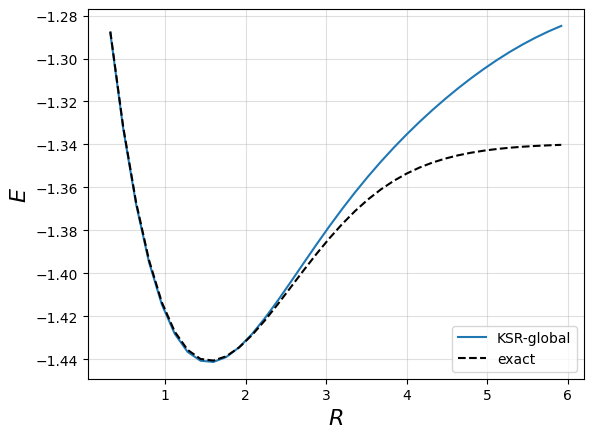

In [14]:
import matplotlib.pyplot as plt

nuclear_energy = utils.get_nuclear_interaction_energy_batch(
    dissoc_dataset.locations,
    dissoc_dataset.nuclear_charges,
    interaction_fn=utils.exponential_coulomb)

distances = utils.compute_distances_between_nuclei(dissoc_dataset.locations, 
  [0,1])

plt.plot(distances, final_states.total_energy + nuclear_energy, 
  label='KSR-global')
plt.plot(distances, dissoc_dataset.total_energies + nuclear_energy, 'k--', 
  label='exact')

plt.xlabel('$R$', fontsize=16)
plt.ylabel('$E$', fontsize=16)
plt.legend()
plt.grid(alpha=0.4)

fig_pdf_name = 'h2_dissoc'
plt.savefig(f'{fig_pdf_name}.pdf', bbox_inches='tight')

Plot a select density

R = 4.96


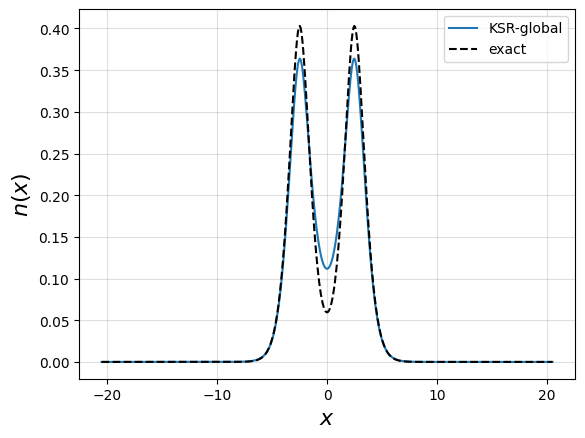

In [15]:
separation = 5.0 
atol = utils.get_dx(dissoc_dataset.grids) / 2
separation_idx = np.where(np.isclose(separation, distances, atol=atol))[0][0]
separation = distances[separation_idx]

plt.plot(dissoc_dataset.grids, final_states.density[separation_idx], 
  label='KSR-global')
plt.plot(dissoc_dataset.grids, dissoc_dataset.densities[separation_idx], 'k--', 
  label='exact')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$n(x)$', fontsize=16)
plt.legend()
plt.grid(alpha=0.4)

print(f'R = {separation}')
fig_pdf_name = 'h2_select_density'
plt.savefig(f'{fig_pdf_name}.pdf', bbox_inches='tight')